## Game play notes
- Player positions run from 0 - 39 (need to mod 40 on every roll)
- 0 - go, 1 = medeter ave, 2 = comm chest ... 39 = boardwalk
- 0 = go, 10 = jail, 20 = free parking, 30 = go to jail
- Railroads in the middle of each lane @ 5, 15, 25, 35
- Utilities 2 away from jails @ 12 & 28
- Tax @ 4 & 38
- Chance at 7, 22, 36
- Community Chest @ 2, 17, 33
    - 1x Go (0)
    - 1x Jail (10)
    - 14x No movement
- Chance has 16 cards
    - 1x Reading Railroad (5)
    - 1x Boardwalk (39)
    - 1x Go (0)
    - 1x Illinois Avenue (24)
    - 1x St. Charles Place (11)
    - 2x nearest Railroad (5, 15, 25, 35)
    - 1x nearest Utility (12, 28)
    - 1x Back 3 Spaces (-3)
    - 1x Go to Jail (10)
    - 6x No movement 

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

### Group by Colours
colour_codes = {(1, 3): "sienna", (6, 8, 9): "cyan", (11, 13, 14): "magenta", \
                (16, 18, 19): "orange", (21, 23, 24): "red", (26, 27, 29): "yellow", \
                (31, 32, 34): "green", (39, 37): "blue"}

colours = ['gray']*40
colours[2] = 'skyblue' ## Comm Chest
colours[7] = 'gold' ## Chance
colours[10] = 'black' ## Jail

for i in range(40):
    for key, value in colour_codes.items():
        if i in key:
            colours[i] = value

### We define a function to roll both die, set the order of our chance and community chest cards (think of it like a shuffle)

In [8]:
def rollDice():
    first = random.randint(1,6)
    second = random.randint(1,6)
    return (int(first + second), first == second)

def set_chance():
    vals = ['Reading Railroad', 'Boardwalk', 'Go', 'Illinois Avenue', 'St. Charles Place', \
            'Nearest Railroad', 'Nearest Railroad', 'Nearest Utility', 'Back 3 Spaces', 'Go to Jail', \
            'No movement', 'No movement', 'No movement', 'No movement', 'No movement', 'No movement']
    random.shuffle(vals)
    return vals

def set_comm_chest():
    vals = ['Go', 'Go to Jail', \
            'No movement', 'No movement', 'No movement', 'No movement', 'No movement', 'No movement', 'No movement', \
            'No movement', 'No movement', 'No movement', 'No movement', 'No movement', 'No movement', 'No movement'
            ]
    random.shuffle(vals)
    return vals

### We define our chance and community chest functions by the notes above

In [9]:
def chance(curr_loc):
    order = set_chance()
    curr_card = order[0]
    cards_loc_dict = {'Reading Railroad': 5, 'Boardwalk': 39, 'Go': 0, 'Illinois Avenue': 24, \
                      'St. Charles Place': 11, 'Go to Jail': 10, 'No movement': curr_loc,}
    
    if curr_card == 'Nearest Railroad':
        if 5 < curr_loc <= 15:
            curr_loc = 15
        elif 15 < curr_loc <= 25:
            curr_loc = 25
        elif 25 < curr_loc <= 35:
            curr_loc = 35
        else:
            curr_loc = 5

    elif curr_card == 'Nearest Utility':
        if 12 < curr_loc <= 28:
            curr_loc = 28
        else:
            curr_loc = 12
    
    elif curr_card == 'Back 3 Spaces':
        curr_loc -= 3
    
    else:
        curr_loc = cards_loc_dict[curr_card]

    return int(curr_loc)

In [10]:
def comm_chest(curr_loc):
    order = set_comm_chest()
    curr_card = order[0]
    cards_loc_dict = {'Go': 0, 'Go to Jail': 10, 'No movement': curr_loc}
    curr_loc = cards_loc_dict[curr_card]

    return int(curr_loc)

### Here, we simulate the game and tabluate the number of times a player lands on each square with the amount of money spent on each property
- We now consider the buying of property rules as follows:
    - If someone has not landed on the property yet, it will be bought
    - Every subsequent landing by the buyer on the property will force the player to improve on the house (+1 house or hotel)
    - Every player has infinite money

In [12]:
property_df = pd.read_csv("Property Data.csv").drop(columns = ['Unnamed: 0', "Name", "Houses Before Hotel"])
num_players = 4
turns = 1000
num_iterations = 100
chance_loc = np.array([7, 22, 36])
comm_chest_loc = np.array([2, 17, 33])
jail = np.zeros(num_players)
position_count = np.zeros(40)

## Including the house, hotel, bought and selling
houses = np.zeros(40) ## How many houses built 1-4, 5 = hotel
available = np.zeros(40) ## Is it available
net_sum = np.zeros(40) ## What is the total amount earned - spent
possible_houses = np.array(property_df['Square']) ## List of possible houses

for n in range(num_iterations):
    player_loc = np.zeros(num_players)
    for turn in range(turns):  
        double_count = 0
        for player in range(num_players):
            double = True

            if jail[player] > 0:
                die, double = rollDice()
                if double:
                    jail[player] = 0
                pass

            while double and double_count < 3:
                die, double = rollDice()

                if double:
                    double_count += 1

                player_loc[player] = int((player_loc[player] + die) % 40)
                current_loc = int(player_loc[player])
                position_count[current_loc] += 1

                if current_loc in chance_loc:
                    current_loc = chance(current_loc)
                    if current_loc == 10:
                        jail[player] = 3
                
                elif current_loc in comm_chest_loc:
                    current_loc = comm_chest(current_loc)
                    if current_loc == 10:
                        jail[player] = 3
                
                ### Include property
                if current_loc in property_df['Square'].values: ## Valid square
                    if available[current_loc] == 0: ## avail square
                        available[current_loc] = player ## sold to player
                        net_sum[current_loc] -= property_df.loc[property_df['Square'] == current_loc, 'Buy Cost'].values[0]
                    
                    else: ## not available
                        current_house_val = int(houses[current_loc])
                        if available[current_loc] == player: ## If the current player owns it, they buy another building
                            if 0 <= current_house_val <= 3: ## Buy a house
                                net_sum[current_loc] -= property_df.loc[property_df['Square'] == current_loc, 'House Cost'].values[0]
                                houses[current_loc] += 1
                            elif current_house_val == 4: ## Buy a hotel
                                net_sum[current_loc] -= property_df.loc[property_df['Square'] == current_loc, 'Hotel Cost'].values[0]
                                houses[current_loc] += 1
                            else: ## Already at a hotel
                                pass 
                            
                        else: ## Current player owes money on this
                            if current_house_val < 5:
                                col_val = f"Rent with {current_house_val} house"
                            else:
                                col_val = "Rent with hotel"
                            net_sum[current_loc] += property_df.loc[property_df['Square'] == current_loc, col_val].values[0]
                
                if jail[player] == 3:
                    break
            
            if double_count == 3:
                current_loc == 10
                jail[player] = 3
                position_count[current_loc] += 1

### Create plots and data visualizations
- We see that the three most visited squares are chance, comm chest, jail in that order
- The Green squares collectively have the most profit

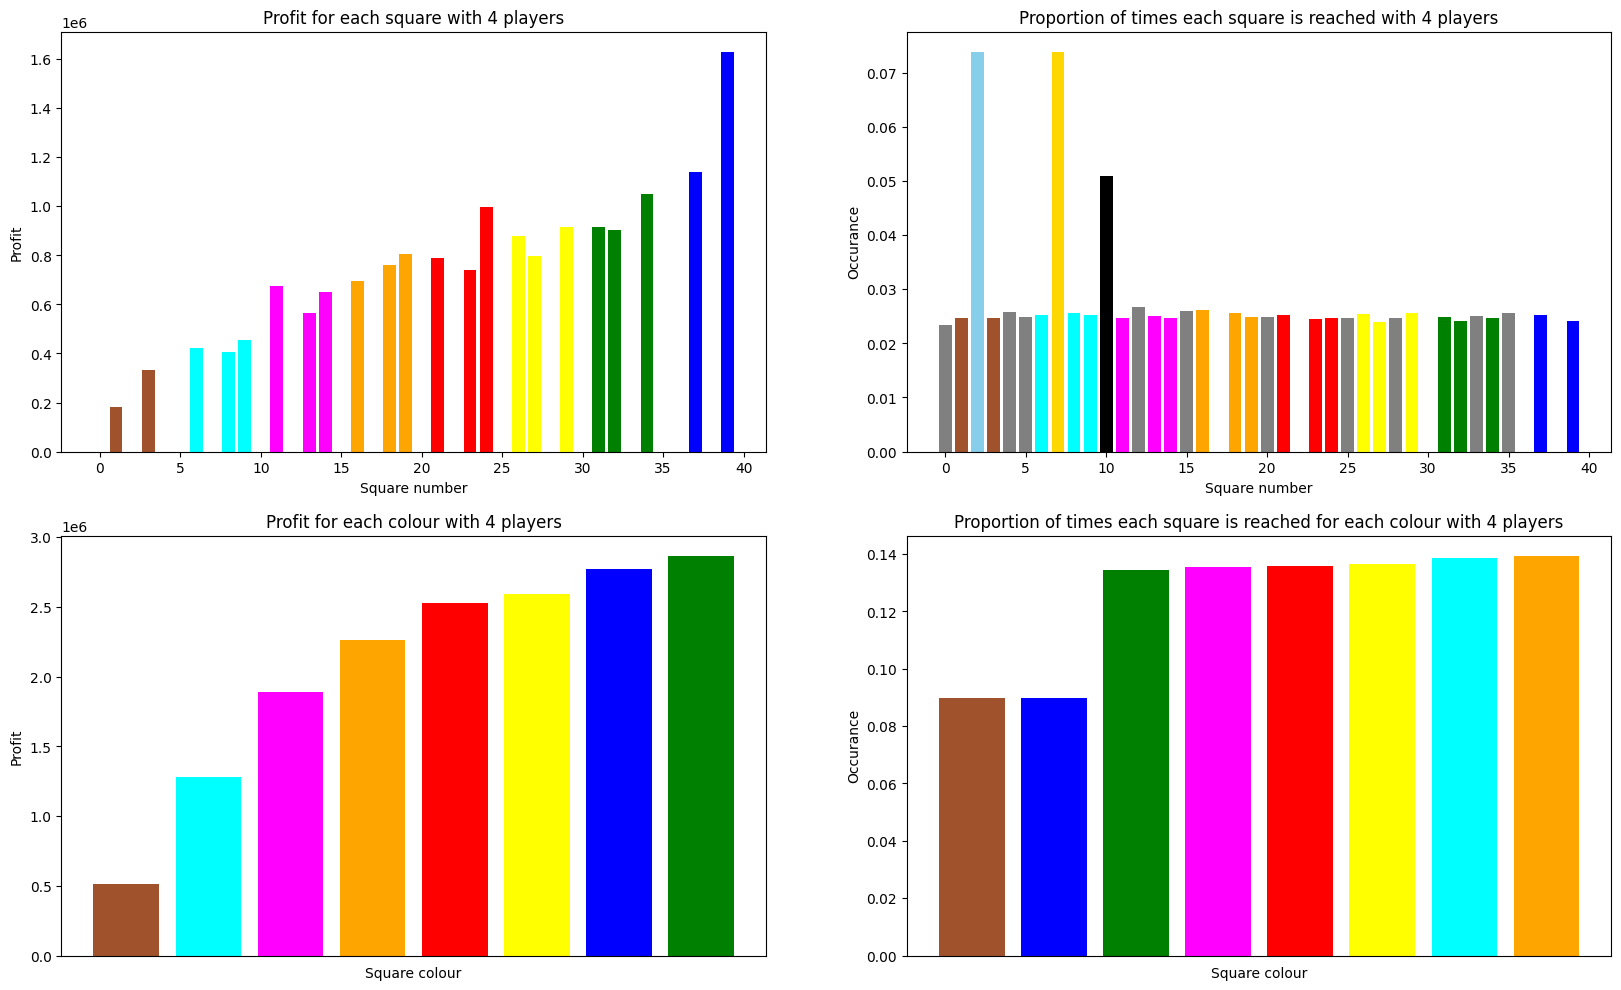

In [ ]:
position_count[10] += position_count[30] ## Jail
position_count[30] = 0

position_count[7] += position_count[22] + position_count[36] ## Chance 
position_count[22] = position_count[36] = 0

position_count[2] += position_count[17] + position_count[38] ## Comm Chest 
position_count[17] = position_count[38] = 0

profit_by_colour = {"sienna": 0, "cyan": 0, "magenta": 0, 'orange': 0,\
                  "red": 0, 'yellow': 0, 'green': 0, 'blue': 0}
occurance_by_colour = {"sienna": 0, "cyan": 0, "magenta": 0, 'orange': 0,\
                  "red": 0, 'yellow': 0, 'green': 0, 'blue': 0}
net_sum_colour = []
profit_colours_list = []

net_occurance_colour = []
occurance_colours_list = []

for i in range(40):
    for key, value in colour_codes.items():
        if i in key:
            profit_by_colour[value] += net_sum[i]
            occurance_by_colour[value] += position_count[i]

sorted_profit_by_colour = dict(sorted(profit_by_colour.items(), key=lambda item: item[1]))
sorted_occurance_by_colour= dict(sorted(occurance_by_colour.items(), key=lambda item: item[1]))

for key, value in sorted_profit_by_colour.items():
    net_sum_colour.append(value)
    profit_colours_list.append(key)

for key, value in sorted_occurance_by_colour.items():
    net_occurance_colour.append(value)
    occurance_colours_list.append(key)

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 12))

axs[0, 0].bar(x = [i for i in range(40)], height = net_sum, color = colours)
axs[0, 0].set_ylabel("Profit")
axs[0, 0].set_xlabel("Square number")
axs[0, 0].set_title(f"Profit for each square with {num_players} players")

axs[0, 1].bar(x = [i for i in range(40)], height = position_count/sum(position_count), color = colours)
axs[0, 1].set_ylabel("Occurance")
axs[0, 1].set_xlabel("Square number")
axs[0, 1].set_title(f"Proportion of times each square is reached with {num_players} players")

axs[1, 0].bar(x = [i for i in range(len(profit_colours_list))], height = net_sum_colour, color = profit_colours_list)
axs[1, 0].set_ylabel("Profit")
axs[1, 0].set_xlabel("Square colour")
axs[1, 0].set_xticks([])
axs[1, 0].set_title(f"Profit for each colour with {num_players} players")

axs[1, 1].bar(x = [i for i in range(len(occurance_colours_list))], height = net_occurance_colour/sum(net_occurance_colour), color = occurance_colours_list)
axs[1, 1].set_ylabel("Occurance")
axs[1, 1].set_xlabel("Square colour")
axs[1, 1].set_xticks([])
axs[1, 1].set_title(f"Proportion of times each square is reached for each colour with {num_players} players")
plt.show()